# Modeling

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import confusion_matrix


from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import datetime
from sklearn.preprocessing import OneHotEncoder
import dill as dill
from joblib import dump

from joblib import load


Загрузка данных

In [2]:
df_sessions = pd.read_pickle('./data/ga_sessions.pkl')
df_hits = pd.read_pickle('./data/ga_hits.pkl')
action = [
    'sub_car_claim_click', 
    'sub_car_claim_submit_click',
    'sub_open_dialog_click', 
    'sub_custom_question_submit_click',
    'sub_call_number_click', 
    'sub_callback_submit_click', 
    'sub_submit_success',
    'sub_car_request_submit_click'
]

#добавим iD клиентов в df_hits
df_hits = df_hits.merge(df_sessions[['session_id', 'client_id']], on='session_id', how='left')

#добавим метку - произошло ли целевое действие в рамках процедуры 1 -да, 0 - нет
df_hits['is_action'] = df_hits['event_action'].isin(action).astype(int)

# создадим таблицу где указано было ли целевое действие в рамках сессии у клиента
df_action_session  = df_hits.groupby(['session_id','client_id'],as_index = False).agg(is_action = ('is_action',max))

In [3]:
# добавим в таблицу df целевую переменную 
df_analys = df_sessions.merge(df_action_session[['session_id', 'is_action']], on='session_id', how='left')

Сделаем критерий отбора по категориальным фичам по критериям:
    1. частота по целевым действиям - топ 20
    2. частота по не целевым действия - топ 5.

In [4]:
cl1 = set(df_analys[df_analys.is_action ==1].groupby('utm_source',as_index =False).agg(action =('is_action','sum')).sort_values('action',ascending =False).head(20).utm_source)
cl0 =set(df_analys[df_analys.is_action ==0].groupby('utm_source',as_index =False).agg(trafic_value =('is_action','count')).sort_values('trafic_value',ascending =False).utm_source.head(5))
cl = cl0|cl1

filter_features = {}
cols =('utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand', 'device_screen_resolution', 'device_browser',
       'geo_country', 'geo_city')
for i in cols:
    cl1 = set(df_analys[df_analys.is_action ==1].groupby(i,as_index =False).agg(action =('is_action','sum')).sort_values('action',ascending =False).head(20)[i])
    cl0 =set(df_analys[df_analys.is_action ==0].groupby(i,as_index =False).agg(trafic_value =('is_action','count')).sort_values('trafic_value',ascending =False).head(5)[i])
    cl = cl0|cl1|{'other'}
    filter_features[i]=cl
    filter_features[i]=cl

### Pipeline _(data processing)_

In [5]:
def new_features(df):
    import numpy as np
    import pandas as pd
    
    # от времени
    df['visit_hour'] = df['visit_time'].str[0:2].astype(int)
    conditions = [ 
    (df['visit_hour'] >= 0) & (df['visit_hour'] <= 7), 
    (df['visit_hour'] >= 8) & (df['visit_hour'] <= 9), 
    (df['visit_hour'] >= 10) & (df['visit_hour'] <= 20), 
    (df['visit_hour'] >= 21) & (df['visit_hour'] <= 23) ] 

    choices = [ 'lowest', 'low', 'high', 'med']

    df['hour_bin'] = np.select(conditions, choices, default='Not Specified')
    
    # от даты
    df.visit_date = pd.to_datetime(df.visit_date)
    df['visit_day'] = df.visit_date.dt.day
    df['visit_month'] = df.visit_date.dt.month
    
    # удалим изначальные признаки
    df = df.drop(['visit_time'],axis = 1)
    
    # от utm_source
    social = ('QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs','IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw','gVRrcxiDQubJiljoTbGm')
    df['is_social'] = df['utm_source'].isin(social)
    
    # от utm_medium
    organic = ('organic', 'referral', '(none)')
    df['is_organic'] = df['utm_medium'].isin(organic)
    
    return df

def fill(df):
    
    # Заменяем пропущенные значения в числовых столбцах на медиану
    for col in df.select_dtypes(['bool','int64','float64']).columns:
        df[col].fillna(df[col].median(), inplace=True)
        
    # Заменяем пропущенные значения в категориальных столбцах на 'unknown'
    for col in df.select_dtypes(['object']).columns:
        df[col].fillna('other', inplace=True)
    
    # заполнение device_os по названию бренда
    brand_os = {'Apple':'iOS','Samsung':'Android','Xiaomi':'Android','Realme':'Android','OPPO':'Android','Vivo':'Android'}
    mask  = df['device_os'].isna() & (df['device_category']=='mobile')
    df.loc[mask,'device_os'] = df.loc[mask, 'device_brand'].map(brand_os).fillna('other')
    
    return df

def filter_cols(df):
    
    filter_features = {'utm_source': {'BHcvLfOaCWvWTykYqHVe',
  'BKeImrJuRDZcHiSSTdzm',
  'DnEUulZAecfGPvdtZBYS',
  'ISrKoXQCxqqYvAZICvjs',
  'IZEXUFLARCUMynmHNBGo',
  'MvfHsxITijuriZxsqZqt',
  'QxAxdyPLuQMEcrdZWdWb',
  'RmEBuqrriAfAVsLQQmhk',
  'ZpYIoDJMcFzVoPFsHGJL',
  'aXQzDWsJuGXeBXexNHjc',
  'bByPQxmDaMXgpHeypKSM',
  'fDLlAcSmythWSCVMvqvL',
  'gVRrcxiDQubJiljoTbGm',
  'hTjLvqNxGggkGnxSCaTm',
  'iNFgfQPqHPBuvGCYtrQE',
  'jaSOmLICuBzCFqHfBdRg',
  'kjsLglQLzykiRbcDiGcD',
  'nSReTmyFtbSjlPrTKoaX',
  'oZCzWSykfixnjMPDNjSU',
  'other',
  'vFcAhRxLfOWKhvxjELkx'},
 'utm_medium': {'(none)',
  '(not set)',
  'banner',
  'blogger_channel',
  'blogger_stories',
  'clicks',
  'cpa',
  'cpc',
  'cpm',
  'cpv',
  'email',
  'organic',
  'other',
  'outlook',
  'post',
  'push',
  'referral',
  'smartbanner',
  'smm',
  'stories',
  'tg'},
 'utm_campaign': {'DsqwamlMwRgMTyspCjFR',
  'FTjNLDyTrXaWYgZymFkV',
  'LEoPHuyFvzoNfnzGgfcd',
  'LTuZkdKfxRGVceoWkVyg',
  'LwJZxKuWmvOhPsaCeRjG',
  'MXqmDyetMTICSSitTjWV',
  'QdLfySaGXolfTBSNVfHn',
  'RoDitORHdzGfGhNCyEMy',
  'SgIUDYUKnyWHVowUOqid',
  'XHNUiSKKGTEpSAlaVMFQ',
  'YCKgTzTDywjcWyQudGch',
  'YDIkQmcjRkpdxGbLLtNN',
  'bJJuEXRheRIxXEaYIXqM',
  'eimRuUrNhZLAYcwRrNXu',
  'gecBYcKZCPMcVYdSSzKP',
  'hkvDVxqLOzGjGaoNiNzN',
  'jqlUOdZBNZYfInQVcZlS',
  'nSReTmyFtbSjlPrTKoaX',
  'other',
  'sbJRYgVfvcnqKJNDDYIr',
  'zxoiLxhuSIFrCeTLQVWZ'},
 'utm_adcontent': {'AdeErYgVTbRcAWtHrMHq',
  'EteMoEECGsaJeMnuvAZD',
  'JNHcPlZPxEMWDnRiyoBf',
  'LLfCasrxQzJIyuldcuWy',
  'PkybGvWbaqORmxjNunqZ',
  'SAVVWaMghGnnvPOqMOIt',
  'SOkCdPxfUcZUzzOdgGES',
  'WAeycgIqKXoOMXPzDUDX',
  'WYLajZgbUhGimwBKDZUH',
  'XSkXBCPfnJjvxbfeewtd',
  'ZKlsrASsGaoEHfwkdKjL',
  'aYAcKhelKzYpXrRYknSP',
  'dUuXlWzvmhDSyclWRhNP',
  'eEkLatVAYTkibdzPIyDi',
  'guyNoEvzgofQvvwExGOq',
  'nNqUcgFgcqQbTVSvgaHr',
  'other',
  'qhEmhjPXvwgEHdBikgEQ',
  'sYzBROYhjSDbFZCpzGyf',
  'vCIpmpaGBnIQhyYNkXqp',
  'xhoenQgDQsgfEPYNPwKO'},
 'utm_keyword': {'BmOOOIoWGHEfxEfoUezs',
  'COtBsnAzfZyRVtvDlhnW',
  'IGUCNvHlhfHpROGclCit',
  'ITfrGJNwVsHBGJMAKoct',
  'JTBldRAXvttfVmCNgppl',
  'JajANoFxoqXfKRNBUhzx',
  'KCcEkEaKEtUilBVMoCAi',
  'RkpOyeEPgcMBSDuHLQcj',
  'UKNBOHebRIIsQRsjNKay',
  'XEayFbemrPYbxFeNbxif',
  'YQXPpoLsxnykCWKhGEmI',
  'ZNhSIPchlbnKwZWcsKzz',
  'aXQzDWsJuGXeBXexNHjc',
  'hAmNSZmQkKQKAjZEGlgb',
  'mIKayglJaKQZvgdtLfqT',
  'other',
  'pHqgLcdBQPSLcrTpLkdr',
  'pucKZkLDtpMDBTobJAJG',
  'puhZPIYqKXeFPaUviSjo',
  'tVtbIKrPSOvrXLCznVVe',
  'xkXwwebfDFpZOOKBcXpE'},
 'device_category': {'desktop', 'mobile', 'other', 'tablet'},
 'device_os': {'Android', 'Linux', 'Macintosh', 'Windows', 'iOS', 'other'},
 'device_brand': {'(not set)',
  'Apple',
  'Asus',
  'Blackview',
  'Google',
  'Huawei',
  'LG',
  'Lenovo',
  'Meizu',
  'Motorola',
  'Nokia',
  'OPPO',
  'OnePlus',
  'Realme',
  'Samsung',
  'Sony',
  'Tecno',
  'Vivo',
  'Xiaomi',
  'ZTE',
  'other'},
 'device_screen_resolution': {'1280x720',
  '1366x768',
  '1440x900',
  '1536x864',
  '1920x1080',
  '360x640',
  '360x720',
  '360x760',
  '360x780',
  '360x800',
  '375x667',
  '375x812',
  '390x844',
  '393x851',
  '393x873',
  '412x892',
  '412x915',
  '414x736',
  '414x896',
  '428x926',
  'other'},
 'device_browser': {'Android Webview',
  'Chrome',
  'Edge',
  'Firefox',
  'MRCHROME',
  'Maxthon',
  'Opera',
  'Puffin',
  'Safari',
  'Safari (in-app)',
  'Samsung Internet',
  'UC Browser',
  'YaBrowser',
  'com.vk.vkclient',
  'other'},
 'geo_country': {'(not set)',
  'Armenia',
  'Belarus',
  'Cyprus',
  'Finland',
  'France',
  'Georgia',
  'Germany',
  'Kazakhstan',
  'Kyrgyzstan',
  'Morocco',
  'Netherlands',
  'Russia',
  'Spain',
  'Sweden',
  'Turkey',
  'Ukraine',
  'United Kingdom',
  'United States',
  'Uzbekistan',
  'other'},
 'geo_city': {'(not set)',
  'Balashikha',
  'Chelyabinsk',
  'Domodedovo',
  'Grozny',
  'Irkutsk',
  'Kazan',
  'Krasnodar',
  'Krasnoyarsk',
  'Moscow',
  'Nizhny Novgorod',
  'Novosibirsk',
  'Rostov-on-Don',
  'Saint Petersburg',
  'Samara',
  'Sochi',
  'Tula',
  'Ufa',
  'Voronezh',
  'Yekaterinburg',
  'other'}}
    for i in filter_features.keys():
        mask = df[i].isin(filter_features[i])
        df.loc[~mask,i] ='other'
        
    cols= ['session_id','client_id','visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_city',
       'visit_hour', 'hour_bin', 'visit_day', 'visit_month', 'is_social',
       'is_organic']
        
    return df.loc[:,cols]

Cохранение

In [6]:
preprocessor = Pipeline(steps=[
        ('new_features', FunctionTransformer(new_features)),
        ('fill', FunctionTransformer(fill)),
        ('filter_cols', FunctionTransformer(filter_cols)),
   ])
df_t = preprocessor.fit_transform(df_sessions)

with open('./models/preprocessor.pkl', 'wb') as f:
    dill.dump(preprocessor, f)

# Подготовка данных для модели

In [7]:
# добавим в таблицу df целевую переменную 
df_t = df_t.merge(df_action_session[['session_id', 'is_action']], on='session_id', how='left')
df_t= df_t[df_t.is_action.notna()].reset_index()
df_t = df_t.drop('index', axis =1)

#### Разделим на обучение и тест

In [8]:
test_size_class_1 = 14000
test_size_class_0 =int((test_size_class_1)/(df_t[df_t.is_action==1].shape[0]/df_t[df_t.is_action==0].shape[0]))
indx_1  = df_t[df_t['is_action'] == 1].sample(n=test_size_class_1, random_state=1,replace=False).index
indx_0  = df_t[df_t['is_action'] == 0].sample(n=test_size_class_0, random_state=1,replace=False).index
indx = set(indx_1)|set(indx_0)

df_clear_test = df_t[df_t.index.isin(indx)].reset_index()
df_clear_test = df_clear_test.drop('index', axis =1)

df = df_t[~df_t.index.isin(indx)].reset_index()
df = df.drop('index', axis =1)

In [9]:
cols_to_train = ['visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_city',
       'visit_hour', 'hour_bin', 'visit_day', 'visit_month', 'is_social',
       'is_organic']

numeric_features = df_t.loc[:,cols_to_train].select_dtypes(include=['int64', 'int32']).columns
categorical_features = df_t.loc[:,cols_to_train].select_dtypes(include=['object']).columns
bool_features = df_t[['is_action','is_organic','is_social']].columns

# создадим объект ohe 
ohe= OneHotEncoder(handle_unknown='ignore')
ohe.fit(df_t[categorical_features])

OneHotEncoder(handle_unknown='ignore')

Сохраним кодер

In [10]:
import joblib
joblib.dump(ohe, 'one_hot_encoder.pkl')

['one_hot_encoder.pkl']

In [ ]:
# Сделаем общий объект OneHotEncoder
ohe = joblib.load('one_hot_encoder.pkl')

# Применение к новым данным
new_data_encoded = ohe.transform(new_data)

In [12]:
def encode_df(df):
    cols_to_train = ['visit_number', 'utm_source',
       'utm_medium', 'utm_campaign', 'utm_adcontent',
       'device_category', 'device_os', 'device_brand',
       'device_screen_resolution', 'device_browser', 'geo_city',
       'visit_hour', 'hour_bin', 'visit_day', 'visit_month', 'is_social',
       'is_organic']

    numeric_features = df.loc[:,cols_to_train].select_dtypes(include=['int64', 'int32']).columns
    categorical_features = df.loc[:,cols_to_train].select_dtypes(include=['object']).columns
    bool_features = df[['is_action','is_organic','is_social']].columns
    
    encoded_features = ohe.transform(df[categorical_features])
    df_encoded = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out())
    df = pd.concat([df[numeric_features], df_encoded,df[bool_features]], axis=1)
    df[numeric_features] = StandardScaler().fit_transform(df[numeric_features])
    return df

# Обучение моделей

# Catboost

In [9]:
from catboost import CatBoostClassifier, Pool

In [10]:
X = df.drop(['is_action','session_id','client_id'],axis = 1)
y = df['is_action']


cols_features = X.select_dtypes(include=['object']).columns
cat_features = [X.columns.get_loc(c) for c in cols_features]

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [11]:
model_cat = CatBoostClassifier(cat_features=cat_features)
model_cat.fit(X_train, y_train,verbose=200)

Learning rate set to 0.18587
0:	learn: 0.4350554	total: 1.6s	remaining: 26m 44s
200:	learn: 0.1222492	total: 4m 46s	remaining: 18m 58s
400:	learn: 0.1209798	total: 9m 57s	remaining: 14m 53s
600:	learn: 0.1200070	total: 15m 10s	remaining: 10m 4s
800:	learn: 0.1190525	total: 20m 7s	remaining: 4m 59s
999:	learn: 0.1182774	total: 25m 14s	remaining: 0us


In [13]:
preds_proba_cat = model_cat.predict_proba(X_valid)[:, 1]
preds_class = (preds_proba_cat > 0.04).astype(int)
auc_pred = roc_auc_score(y_valid, preds_proba_cat)
precision = precision_score(y_valid, preds_class)
recall = recall_score(y_valid, preds_class)
f1 = f1_score(y_valid, preds_class)

print(f"Mean AUC: {auc_pred}")
print(f"Mean Precision: {precision}")
print(f"Mean Recall: {recall}")
print(f"Mean F1 Score: {f1}")

Mean AUC: 0.7024136964904498
Mean Precision: 0.0657745947983415
Mean Recall: 0.44727206151592824
Mean F1 Score: 0.11468406722373486


# LightGBM

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_auc_score, confusion_matrix
from lightgbm import Dataset
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping

F:\ANACONDA\envs\py_sp\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


ROC AUC: 0.7036690420976551


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

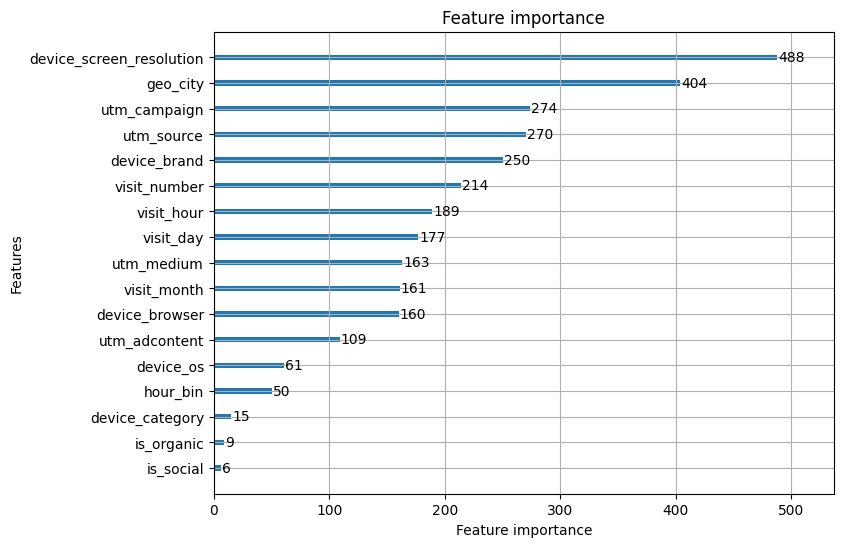

In [18]:
X = df.drop(['is_action','session_id','client_id'],axis = 1)
y = df['is_action']

cols_features = X.select_dtypes(include=['object']).columns
cat_features = [X.columns.get_loc(c) for c in cols_features]

le = LabelEncoder()
for col in cols_features:
    X[col] = le.fit_transform(X[col])
y= y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

train_data = lgb.Dataset(X_train, label=y_train,categorical_feature=cat_features, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test,categorical_feature=cat_features, free_raw_data=False)


params = {
    'objective': 'binary', #regression, binary, tweedie, cross_entropy
    'metric': 'binary_logloss',
    'boosting_type': 'goss', #градиеный бустинг над решающими деревьями (используется по умолчанию) есть еще dart, goss 
    'learning_rate': 0.07, # default = 0.1
    'num_leaves': 31, # максимальное количество листьев, разрешенное для каждого дерева.default = 31
    'max_depth': -1, # любая глубина дерева. default = -1
    'min_child_samples': 20,
    'max_bin': 255,
    'subsample': 1,
    'subsample_freq': 1,
    'colsample_bytree': 1,
    'min_child_weight': 0.001,
    'min_split_gain': 0,
    'n_estimators': 100,
    'seed': 0,
    'silent': True,
    'verbosity': -1,
    'is_unbalance': True
}

# Обучение модели
model_lgb = lgb.train(params, 
                train_set=train_data,
                valid_sets=(test_data),
                #callbacks=[lgb.early_stopping(stopping_rounds=100)],
                categorical_feature=cat_features,
                num_boost_round=300,)

y_pred_lgb = model_lgb.predict(X_test)
y_pred_binary = (y_pred_lgb >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_pred_lgb)

print(f"ROC AUC: {roc_auc}")

lgb.plot_importance(model_lgb, figsize=(8, 6), importance_type="split")


# XGBoost

In [19]:
import xgboost as xgb

In [20]:
X = df.drop(['is_action','session_id','client_id'],axis = 1)
y = df['is_action']

cols_features = X.select_dtypes(include=['object']).columns
for col in cols_features:
    X[col] = X[col].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [21]:
params = {
    'objective': 'binary:logistic',# binary:hinge, reg:squarederror
    'tree_method': 'hist',  
    'seed': 42,
}

model_xgb = xgb.train(params,
                      dtrain=dtrain,
                      num_boost_round=30,
                      evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
                      early_stopping_rounds=10,
                      verbose_eval=5)

[0]	dtrain-logloss:0.17123	dtest-logloss:0.17190
[5]	dtrain-logloss:0.12892	dtest-logloss:0.13020
[10]	dtrain-logloss:0.12354	dtest-logloss:0.12530
[15]	dtrain-logloss:0.12219	dtest-logloss:0.12441
[20]	dtrain-logloss:0.12153	dtest-logloss:0.12417
[25]	dtrain-logloss:0.12105	dtest-logloss:0.12402
[29]	dtrain-logloss:0.12075	dtest-logloss:0.12398


ROC AUC: 0.7029963403515278


<Axes: title={'center': 'Feature Importance Weight'}, xlabel='F score', ylabel='Features'>

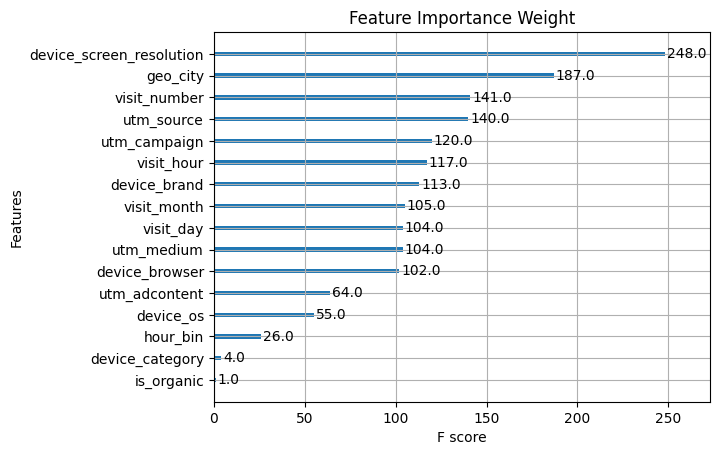

In [22]:
y_pred_xgb = model_xgb.predict(dtest)
y_pred_binary = (y_pred_xgb >= 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_pred_xgb)

print(f"ROC AUC: {roc_auc}")

xgb.plot_importance(model_xgb, title='Feature Importance Weight')

## Logistic regression

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score, precision_score

In [24]:
df_sc = encode_df(df)

X = df_sc.drop(['is_action'],axis = 1)
y = df_sc['is_action']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model_logistic = LogisticRegression(
    class_weight='balanced',
    #C=0.5,
    #penalty='l1', 
    #solver='liblinear',
)
model_logistic.fit(X_train, y_train)


y_pred = model_logistic.predict(X_test)
y_pred_proba = model_logistic.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

F:\ANACONDA\envs\py_sp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC AUC: 0.670622852962961


## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [26]:
df_sc = encode_df(df)

X = df_sc.drop(['is_action'],axis = 1)
y = df_sc['is_action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model_rf = RandomForestClassifier(
    n_estimators=300,  # Число деревьев в лесу
    criterion='entropy',  # Функция измерения качества разбиения
    max_depth=None,  # Максимальная глубина дерева
    min_samples_split=2,  # Минимальное количество образцов, необходимое для разделения узла
    min_samples_leaf=23,  # Минимальное количество образцов, требуемое на листовом узле
    random_state=42,  # Зерно для генератора случайных чисел
    max_features = 'sqrt',
    bootstrap = True)

model_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=23,
                       n_estimators=300, random_state=42)

In [28]:
y_pred = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.7025011789717422


# FNN Keras

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [30]:
df_sc = encode_df(df)

X = df_sc.drop(['is_action'],axis = 1)
y = df_sc['is_action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[:988200]
y_train =y_train[:988200]

X_train = tf.convert_to_tensor(X_train.astype(np.float32))
y_train = y_train.astype(np.float32)
X_test = tf.convert_to_tensor(X_test.astype(np.float32))


In [31]:
scores =[]


for i in range(1):
    EPOCHS =15
    BATCH_SIZE = 49410
    num_input_features = X_train.shape[1]

    model_keras = Sequential()
    model_keras.add(Dense(512, activation='relu', input_shape=(num_input_features,), name = 'h1'))
    model_keras.add(Dropout(0.2))
    model_keras.add(Dense(256, activation='relu'))
    model_keras.add(Dropout(0.2))
    model_keras.add(Dense(128, activation='relu'))
    model_keras.add(Dropout(0.1))
    model_keras.add(Dense(32, activation='relu'))
    model_keras.add(Dropout(0.1))
    model_keras.add(Dense(1, activation='sigmoid'))

    
    learning_rate = 0.002
    adam_optimizer = Adam(learning_rate=learning_rate) #sgd, adam, RMSprop
    
    model_keras.compile(
        optimizer=adam_optimizer, 
        loss='binary_crossentropy', 
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )

    model_keras.fit(X_train,y_train,batch_size =BATCH_SIZE, epochs =EPOCHS)

    y_preds = model_keras(X_test)
    roc_auc = roc_auc_score(y_test, y_preds)
    scores.append(roc_auc)
    print(f'Значение ROC AUC на модели нейронной сети {scores[0]}')

Epoch 1/15
20/20 [==============================] - 29s 1s/step - loss: 0.2105 - auc: 0.5182
Epoch 2/15
20/20 [==============================] - 27s 1s/step - loss: 0.1362 - auc: 0.5968
Epoch 3/15
20/20 [==============================] - 32s 2s/step - loss: 0.1317 - auc: 0.6217
Epoch 4/15
20/20 [==============================] - 32s 2s/step - loss: 0.1299 - auc: 0.6365
Epoch 5/15
20/20 [==============================] - 33s 2s/step - loss: 0.1289 - auc: 0.6443
Epoch 6/15
20/20 [==============================] - 32s 2s/step - loss: 0.1278 - auc: 0.6548
Epoch 7/15
20/20 [==============================] - 32s 2s/step - loss: 0.1271 - auc: 0.6600
Epoch 8/15
20/20 [==============================] - 36s 2s/step - loss: 0.1266 - auc: 0.6662
Epoch 9/15
20/20 [==============================] - 34s 2s/step - loss: 0.1262 - auc: 0.6712
Epoch 10/15
20/20 [==============================] - 32s 2s/step - loss: 0.1257 - auc: 0.6763
Epoch 11/15
20/20 [==============================] - 32s 2s/step - lo

# FNN Pytorch

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader, TensorDataset

In [33]:
num_input_features = X_train.shape[1]
EPOCHS = 5
BATCH_SIZE = 1647
learning_rate=0.005

df_sc = encode_df(df)

X = df_sc.drop(['is_action'],axis = 1)
y = df_sc['is_action']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train[:988200].astype(np.float32)
y_train =y_train[:988200].astype(np.float32)
X_test = X_test.astype(np.float32) # лучше чтобы тип был один
y_test = y_test.astype(np.float32) # лучше чтобы тип был один

X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values).view(-1, 1) # тензор должен быть двумерный
X_test_tensor = torch.tensor(X_test.values)
y_test_tensor = torch.tensor(y_test.values).view(-1, 1) # тензор должен быть двумерный

# переведем в класс DataLoader перемешивания и подачи пакетами
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print (f'Входной тензор{X_train_tensor.shape}')
print (f'Вектор ответов тензор{y_train_tensor.shape}')

Входной тензорtorch.Size([988200, 181])
Вектор ответов тензорtorch.Size([988200, 1])


In [34]:
class NeuralNet(nn.Module):
    def __init__(self, num_input_features):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(num_input_features, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 32)
        self.layer5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout2(x)
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.relu(self.layer3(x))
        x = self.dropout1(x)
        x = self.relu(self.layer4(x))
        x = self.dropout1(x)
        x = self.sigmoid(self.layer5(x))
        return x

# Создаем модель как экземпляр класса NeuralNet
model = NeuralNet(num_input_features)
criterion = nn.BCELoss() # бинарная кросс-энтропия 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
# Обучение модели
verbose = 100

model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs) # outputs предсказания на текущем пакете
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % verbose == verbose-1:
            print(f'Эпоха {epoch + 1}, Батч {i + 1}, Потеря: {running_loss / verbose:.4f}')
            running_loss = 0.0

Эпоха 1, Батч 100, Потеря: 0.1499
Эпоха 1, Батч 200, Потеря: 0.1312
Эпоха 1, Батч 300, Потеря: 0.1309
Эпоха 1, Батч 400, Потеря: 0.1300
Эпоха 1, Батч 500, Потеря: 0.1276
Эпоха 1, Батч 600, Потеря: 0.1273
Эпоха 2, Батч 100, Потеря: 0.1261
Эпоха 2, Батч 200, Потеря: 0.1268
Эпоха 2, Батч 300, Потеря: 0.1264
Эпоха 2, Батч 400, Потеря: 0.1310
Эпоха 2, Батч 500, Потеря: 0.1267
Эпоха 2, Батч 600, Потеря: 0.1251
Эпоха 3, Батч 100, Потеря: 0.1253
Эпоха 3, Батч 200, Потеря: 0.1270
Эпоха 3, Батч 300, Потеря: 0.1270
Эпоха 3, Батч 400, Потеря: 0.1268
Эпоха 3, Батч 500, Потеря: 0.1234
Эпоха 3, Батч 600, Потеря: 0.1246
Эпоха 4, Батч 100, Потеря: 0.1228
Эпоха 4, Батч 200, Потеря: 0.1250
Эпоха 4, Батч 300, Потеря: 0.1272
Эпоха 4, Батч 400, Потеря: 0.1249
Эпоха 4, Батч 500, Потеря: 0.1240
Эпоха 4, Батч 600, Потеря: 0.1252
Эпоха 5, Батч 100, Потеря: 0.1264
Эпоха 5, Батч 200, Потеря: 0.1220
Эпоха 5, Батч 300, Потеря: 0.1246
Эпоха 5, Батч 400, Потеря: 0.1261
Эпоха 5, Батч 500, Потеря: 0.1234
Эпоха 5, Батч 

In [36]:
# Оценка модели
model.eval()
with torch.no_grad():
    y_preds = model(X_test_tensor)
    roc_auc = roc_auc_score(y_test_tensor.numpy(), y_preds.numpy())
    print(f'Значение ROC AUC на модели нейронной сети: {roc_auc}')


Значение ROC AUC на модели нейронной сети: 0.6959653900124723


## ТЕСТЫ

In [20]:
# Матрица ответов модели
def conf(y_test,y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Создание матрицы ошибок с подписями
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'])   
    plt.yticks(ticks=[0.5, 1.5], labels=['Class 0', 'Class 1'])  
    plt.show()

#### Catboost

Значение ROC AUC на модели CatBoost 0.7044324714007635


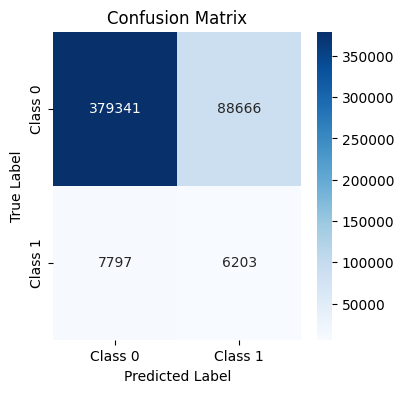

In [21]:
X_test = df_clear_test.drop(['is_action','session_id','client_id'],axis = 1)
y_test = df_clear_test['is_action']

cols_features_test = X_test.select_dtypes(include=['object']).columns
cat_features_test = [X_test.columns.get_loc(c) for c in cols_features]

preds_proba_cat = model_cat.predict_proba(X_test)[:, 1]
y_pred_cat = (preds_proba_cat >= 0.04).astype(int)
auc_pred = roc_auc_score(y_test, preds_proba_cat)

print(f'Значение ROC AUC на модели CatBoost {auc_pred}')
conf(y_test,y_pred_cat)

roc_auc = auc_pred

#### lightGbm

Значение ROC AUC на модели LGBM 0.7055436021408715


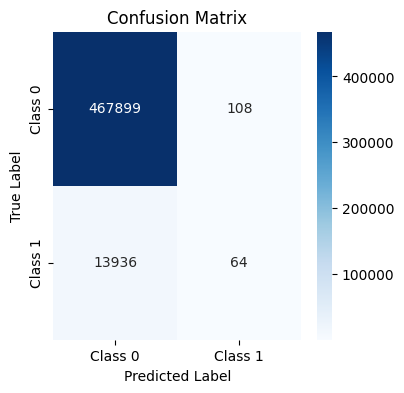

In [39]:
X_clear_test = df_clear_test.drop(['is_action','session_id','client_id'],axis = 1)
y_clear_test = df_clear_test['is_action']

cols_features_test = X_clear_test.select_dtypes(include=['object']).columns
cat_features_test = [X_clear_test.columns.get_loc(c) for c in cols_features]
for col in cols_features:
    X_clear_test[col] = le.fit_transform(X_clear_test[col])
    
y_clear_test= y_clear_test.astype(int)
preds_proba_lgb= model_lgb.predict(X_clear_test)
y_pred_lgb = (preds_proba_lgb >= 0.85).astype(int)
roc_auc = roc_auc_score(y_clear_test, preds_proba_lgb)
print(f'Значение ROC AUC на модели LGBM {roc_auc}')
conf(y_clear_test,y_pred_lgb)



In [40]:
conf_matrix = confusion_matrix(y_clear_test,y_pred_lgb)

print(f'Pressision: {conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])} Стратегия - лучше проставить нули и не ошибаться в 1. ВАЖНА ТОЧНОСТЬ ОПРЕДЕЛЕНИЯ ЕДИНИЦ')
print(f'Recall: {conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0])} Нужно найти максимум 1, не важно что много ошибемся в 0 классе')

Pressision: 0.37209302325581395 Стратегия - лучше проставить нули и не ошибаться в 1. ВАЖНА ТОЧНОСТЬ ОПРЕДЕЛЕНИЯ ЕДИНИЦ
Recall: 0.004571428571428572 Нужно найти максимум 1, не важно что много ошибемся в 0 классе


Precision - это ТОЧНОСТЬ в опредлении 1 ого класса, ценой чт
Recall  - это Полноста нахождения 1-ого класса, ценой ошибки в 0-ом классе

#### XGBoost

Значение ROC AUC на модели LGBM 0.7035314203938952


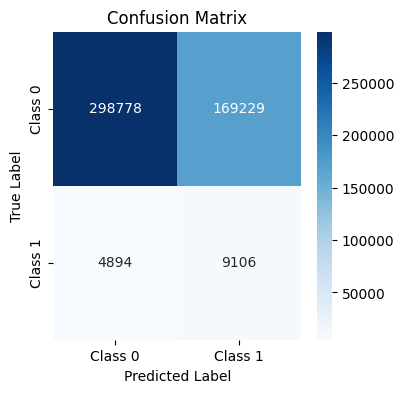

In [41]:
X_test = df_clear_test.drop(['is_action','session_id','client_id'],axis = 1)
y_test = df_clear_test['is_action']

cols_features_test = X_test.select_dtypes(include=['object']).columns
for col in cols_features_test:
    X_test[col] = X_test[col].astype('category')

dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


preds_proba_xgb= model_xgb.predict(dtest)
y_pred_xgb = (preds_proba_xgb >= 0.03).astype(int)
roc_auc = roc_auc_score(y_test, preds_proba_xgb)
print(f'Значение ROC AUC на модели LGBM {roc_auc}')
conf(y_test,y_pred_xgb)

#### Нейросеть на Keras

Значение ROC AUC на модели нейросети 0.6974786862162318


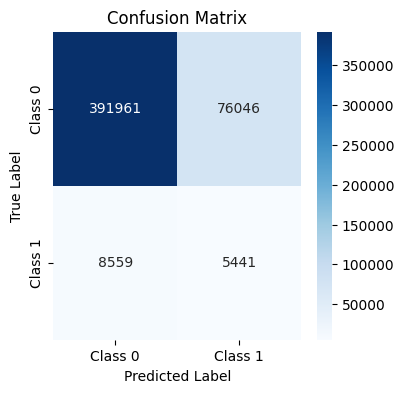

In [42]:
df_sc_test = encode_df(df_clear_test)

X_clear_test= df_sc_test.drop(['is_action'],axis = 1)
y_clear_test= df_sc_test['is_action']


X_clear_test = tf.convert_to_tensor(X_clear_test.astype(np.float32))
y_preds_NN_proba = model_keras(X_clear_test)
y_preds_NN = (y_preds_NN_proba.numpy().reshape(482007,)>= 0.05).astype(int)
roc_auc_clear = roc_auc_score(y_clear_test, y_preds_NN_proba)
print(f'Значение ROC AUC на модели нейросети {roc_auc_clear}')
conf(y_clear_test,y_preds_NN)

#### Нейросеть на Pytorch

Значение ROC AUC на модели нейронной сети Torch: 0.6993185019515886


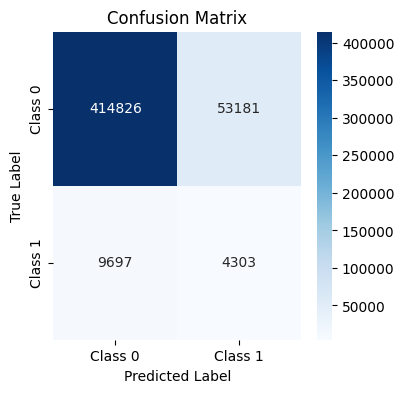

In [43]:
df_sc_test = encode_df(df_clear_test)

X_clear_test= df_sc_test.drop(['is_action'],axis = 1).astype(np.float32)
y_clear_test= df_sc_test['is_action'].astype(np.float32)

X_clear_test_tensor = torch.tensor(X_clear_test.values)
y_clear_test_tensor = torch.tensor(y_clear_test.values).view(-1, 1)

model.eval()
with torch.no_grad():
    y_preds_torch = model(X_clear_test_tensor)
    roc_auc = roc_auc_score(y_clear_test_tensor.numpy(), y_preds_torch.numpy())
    print(f'Значение ROC AUC на модели нейронной сети Torch: {roc_auc}')


conf(y_clear_test,(y_preds_torch.numpy().reshape(482007,)>= 0.05).astype(int))

#### Случайный лес

Значение ROC AUC на Случайном лесу 0.7069172376542598


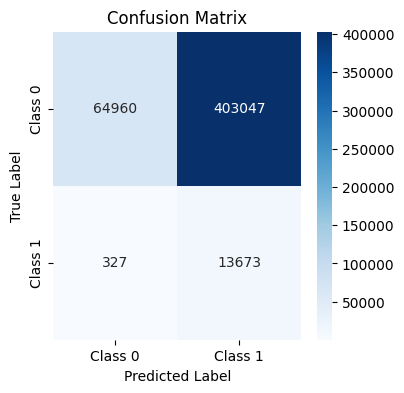

In [44]:
df_sc_test = encode_df(df_clear_test)

X_clear_test= df_sc_test.drop(['is_action'],axis = 1)
y_clear_test= df_sc_test['is_action']

y_preds_rf_proba = model_rf.predict_proba(X_clear_test)[:, 1]

y_pred_rf = (y_preds_rf_proba >= 0.01).astype(int)
roc_auc_clear = roc_auc_score(y_clear_test, y_preds_rf_proba)
print(f'Значение ROC AUC на Случайном лесу {roc_auc_clear}')
conf(y_clear_test,y_pred_rf)


# BLENDING

In [45]:
Blend =pd.DataFrame({'cat':preds_proba_cat,
                     'lgb':preds_proba_lgb,
                     'xgb':preds_proba_xgb, 
                     'rf':y_preds_rf_proba, 
                     'Fnn_keras':y_preds_NN_proba.numpy().reshape(482007,),
                    'Fnn_torch':y_preds_torch.numpy().reshape(482007,)})

w=[0.4, 0.05, 0.05, 0.5, 0.0, 0.0]
Blend['total'] =Blend.cat*w[0] + Blend.lgb*w[1] + Blend.xgb*w[2] +Blend.rf*w[3] +Blend.Fnn_keras*w[4] +Blend.Fnn_torch*w[5] 
roc_auc = roc_auc_score(y_clear_test, Blend.total)

print (f'ROC AUC после блендинга {roc_auc} ')


ROC AUC после блендинга 0.710316437269406 


При блендинге наибольшие веса Catboost и RandomForest дали лучший результат. Для пайплана возьмем Catboost, посколку он работает быстрее чем RandomForest.  

Визуализируем результат на чистом тесте

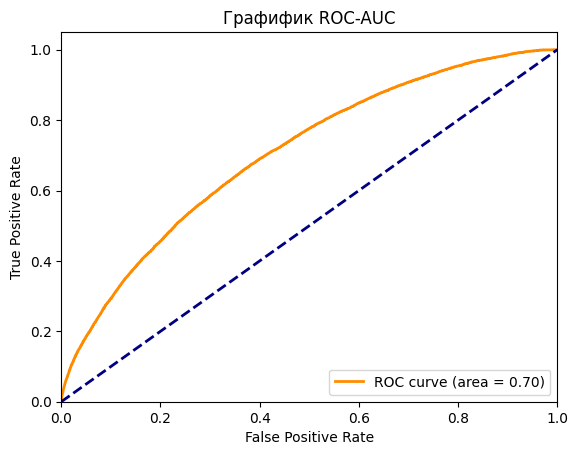

In [46]:
fpr, tpr, _ = roc_curve(df_clear_test['is_action'], preds_proba_cat)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Графифик ROC-AUC')
plt.legend(loc="lower right")
plt.show()

In [23]:
import joblib
filename = './cars_subscribe_model_1.joblib'


model_info = {
    'model': model_cat,
    'info': {
        'model_type': type(model_cat),
        'description': 'Модель предсказания целевых действий по автоподписке',
        'date': datetime.datetime.now().isoformat(),
        'version': '13.0',
        'autor': 'Kolontay Artem',
        'ROC-AUC': roc_auc
    }
}

joblib.dump(model_info, filename)

['./cars_subscribe_model_1.joblib']